# Kermit as hate speech recognizer

![title](./imgs/kermit.jpg)

This notebook contains all the helpful instructions for generating and training Kermit as _hate speech recognizer_.

As an example dataset, we will use the [Davidson dataset](https://ojs.aaai.org/index.php/ICWSM/article/view/14955).

For the construction of dtk - useful for the use of the model - please consult the basic version of Kermit in which is contained a script for their creation

# Import the libraries

In [ ]:
import transformers
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertConfig, BertModel
from pytorch_transformers import XLNetConfig, XLNetModel

In [ ]:
from torch import optim
from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import pickle

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import metrics

**Set seed and random state values**

In [ ]:
SEED = 27
RANDOM_STATE = 5480

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Import the Davidson dataset as pandas dataframes


The structure of the dataset is descrive above:
* 0 --> Hate speech (1430 comments)
* 1 --> Offensive language (19190 comments)
* 2 --> Neither (4163 comments)

In [7]:
df = pd.read_csv('./Datasets/Davidson_dataset.csv')

df.head()

,label,tweet
0,2,As a woman you shouldn't complain about cleani...
1,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,1,UrKindOfBrand Dawg!!!! You ever fuck a bitch...
3,1,she look like a tranny
4,1,The shit you hear about me might be true or it...


# Convert the input in Tensors

In [ ]:
sentences = df.tweet.values
labels = df.label.values

In [ ]:
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [ ]:
MAX_LEN = 128
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

**Import the dtk trees of the Davidson dataset**

In [ ]:
def unplickle_trees(path_tree_file):
    print('--->read DTKs')
    dt_trees = []
    with open(path_tree_file, 'rb') as fr:
        try:
            while True:
                dt_trees.append(pickle.load(fr))
        except EOFError:
            pass
    return [torch.FloatTensor(i) for i in dt_trees]

trees = unplickle_trees("./Datasets/dtk_Davidson.pkl")  # <-- Import the trees in .pkl

In [ ]:
X_inputs, test_inputs, X_labels, test_labels = train_test_split(input_ids, labels, random_state=RANDOM_STATE, test_size=0.1)
X_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=RANDOM_STATE, test_size=0.1)
X_trees, test_trees, _, _ = train_test_split(trees, input_ids, random_state=RANDOM_STATE, test_size=0.1)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(X_inputs, X_labels, random_state=RANDOM_STATE, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(X_masks, X_inputs, random_state=RANDOM_STATE, test_size=0.1)
train_trees, validation_trees, _, _ = train_test_split(X_trees, X_inputs, random_state=RANDOM_STATE, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_trees = torch.stack(train_trees)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_trees = torch.stack(validation_trees)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)
test_trees = torch.stack(test_trees)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_trees, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_trees, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_trees, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Define the model

Kermit for HSE (called _Kermit\_lightning\_bolt_ for the fully connected network at the top) is defined as in the following image:

<div>
<img src="./imgs/architecture.png" width="500"/>
</div>

In [ ]:
class Kermit_lightning_bolt(nn.Module):
    def __init__(self, input_dim_bert, input_dim_dt, output_dim):
        super().__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased').to("cuda" if torch.cuda.is_available() else "cpu")
        self.dropout = nn.Dropout(0.1)
        
        self.fc1 = torch.nn.Linear(input_dim_dt, 2000)
        self.fc2 = torch.nn.Linear(2000, 4000)
        self.fc3 = torch.nn.Linear(4000, 2000)
        self.fc4 = torch.nn.Linear(2000, 4000)

        self.synth_sem_linear = nn.Linear(input_dim_bert + 4000, output_dim)


    def forward(self, x_sem, attention_mask, x_synth):
        with torch.no_grad():
            x_sem = self.bert(x_sem)[0][:, 0, :]
        
        x_sem = self.dropout(x_sem)
        
        x_synth = F.dropout(F.relu(self.fc1(x_synth)), p=0.1)
        x_synth = F.dropout(F.relu(self.fc2(x_synth)), p=0.1)
        x_synth = F.dropout(F.relu(self.fc3(x_synth)), p=0.1)
        x_synth = F.dropout(F.relu(self.fc4(x_synth)), p=0.1)
        
        x_tot = torch.cat((x_sem, x_synth), 1)
        x_tot = self.synth_sem_linear(x_tot)
        
        return x_tot
    
    def get_activation(self, x_sem, x_synth):
        with torch.no_grad():
            x_sem = self.bert(x_sem)[0][:, 0, :]
        
        pooled_output = self.dropout(pooled_output)         
        x_tot = torch.cat((pooled_output, x_synth), 1)
        x_tot = self.synth_sem_linear(x_tot)
        
        return out

In [ ]:
model = Kermit_lightning_bolt(768,4000,3)

unique, counts = np.unique(labels, return_counts = True)

weights = [1/counts[0], 1/counts[1], 1/counts[2]]
class_weights = torch.FloatTensor(weights).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [ ]:
model.cuda()

**Function to select the class of an item in the testing phase according to the highest probability**

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training and validation phase

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4
epoch = 0

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
    model.train()  
      # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        #print(step, batch)
        # Add batch to GPU
        batch = tuple(t.cuda() for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask,b_input_tree, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        
        #NB anche BertForSequenceClassification prende in input anche b_input_tree ma non li usa (solo per comodità)
        target_hat = model(b_input_ids, b_input_mask,b_input_tree)
        
        loss = criterion(target_hat, b_labels)
        train_loss_set.append(loss.item())
        
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    ## VALIDATION

  # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.cuda() for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_input_tree, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            
          # Forward pass, calculate logit predictions
        
        #NB anche BertForSequenceClassification prende in input anche b_input_tree ma non li usa (solo per comodità)
          logits = model(b_input_ids, b_input_mask, b_input_tree)
            
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        
    epoch +=1
    
    print("Epochs: {}".format(epoch))
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# Prediction phase

In [22]:
predictions = []
model.eval()

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_input_tree, b_labels = batch

    with torch.no_grad():
        logits =model(b_input_ids, b_input_mask, b_input_tree)
    logits = logits.detach().cpu().numpy()

    predictions.append(logits)
    
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Print the results

Here, we use the confusion matrix and a report of all measures

In [24]:
c_m = confusion_matrix(test_labels.numpy(), flat_predictions)

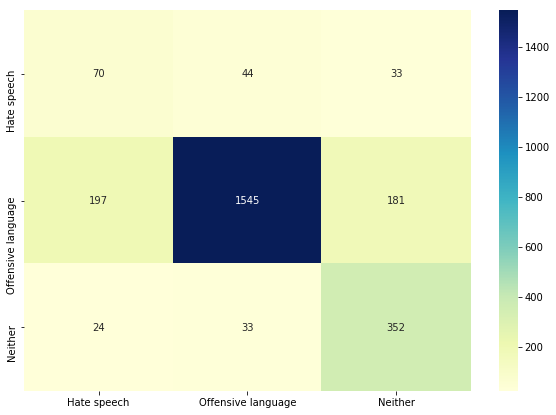

In [25]:
target = ['Hate speech', 'Offensive language', 'Neither']

df_cm = pd.DataFrame(c_m, index = [i for i in target],
                  columns = [i for i in target])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')

In [26]:
print(metrics.classification_report(test_labels.numpy(), flat_predictions))

              precision    recall  f1-score   support

           0       0.24      0.48      0.32       147
           1       0.95      0.80      0.87      1923
           2       0.62      0.86      0.72       409

    accuracy                           0.79      2479
   macro avg       0.60      0.71      0.64      2479
weighted avg       0.86      0.79      0.81      2479

